In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import pydicom as dicom
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import shutil
import zipfile
import glob
import os
from tqdm import tqdm
import random
random.seed(42)
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
images = "/kaggle/input/isic-image-folder"
df_metadata = pd.read_csv('/kaggle/input/ground-truth/challenge-2017-training_metadata_2025-03-31.csv')

dataset = "/kaggle/working/dataset"
if os.path.exists(dataset):
    shutil.rmtree(dataset)
os.makedirs(dataset)

os.makedirs(os.path.join(dataset, "malignant"))
os.makedirs(os.path.join(dataset, "benign"))

indeterminant = "/kaggle/working/indeterminant"
if os.path.exists(indeterminant):
    shutil.rmtree(indeterminant)
os.makedirs(indeterminant)

classes = ["malignant", "benign"]
for _, row in tqdm(df_metadata.iterrows(), total=len(df_metadata), desc="Moving Files", unit="file"):
    image_id = row["isic_id"]
    label = row["benign_malignant"]

    if label in classes:
        source = os.path.join(images, f"{image_id}.jpg")
        destination = os.path.join(dataset, label, f"{image_id}.jpg")
        shutil.copy(source, destination)

    else:
        source = os.path.join(images, f"{image_id}.jpg")
        destination = os.path.join(indeterminant, f"{image_id}.jpg")
        shutil.copy(source, destination)

print("Dataset created")

Moving Files: 100%|██████████| 2000/2000 [00:18<00:00, 105.42file/s]

Dataset created


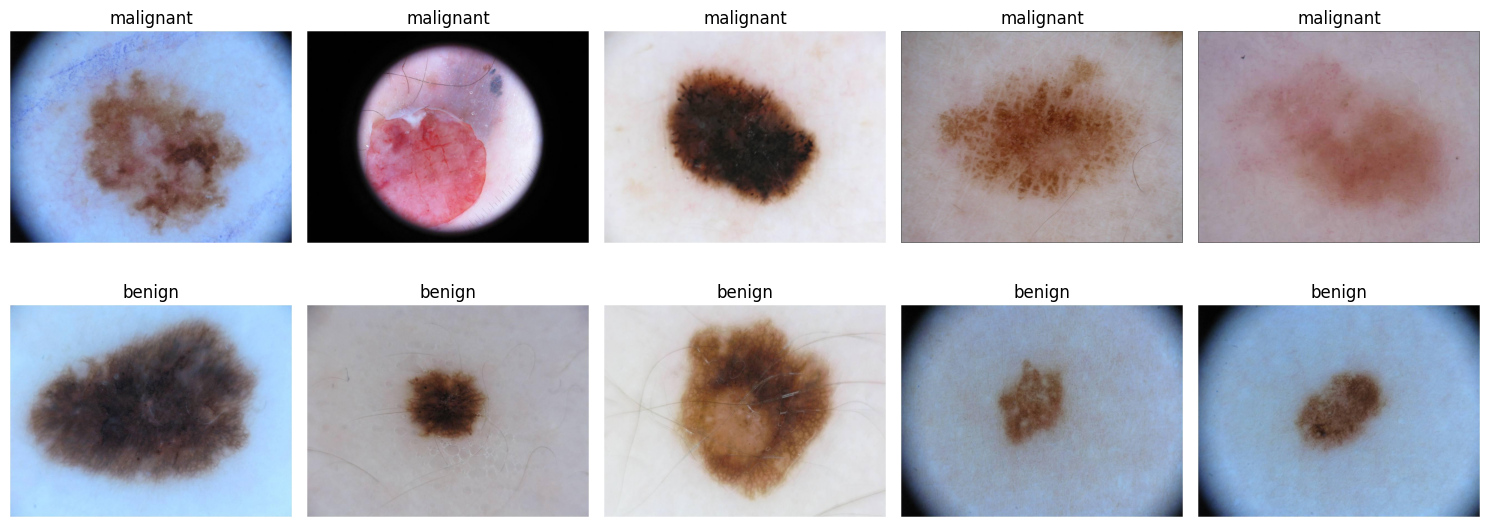

In [3]:
fig, axes = plt.subplots(len(classes), 5, figsize=(15,6))

for i, cls in enumerate(classes):
    class_path = os.path.join(dataset, cls)
    image_files = sorted(os.listdir(class_path))[:5]

    for j, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)

        axes[i,j].imshow(img)
        axes[i,j].axis("off")
        axes[i,j].set_title(cls)

plt.tight_layout()
plt.show()

In [4]:
image_path = '/kaggle/working/dataset'

batch_size = 32
img_size = (256, 256)

ds_train = tf.keras.utils.image_dataset_from_directory(
    image_path,
    labels='inferred',
    class_names=classes,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

ds_val = tf.keras.utils.image_dataset_from_directory(
    image_path,
    labels='inferred',
    class_names=classes,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

normalization = tf.keras.layers.Rescaling(1./255)
ds_train = ds_train.map(lambda x, y:(normalization(x), y))
ds_val = ds_val.map(lambda x, y: (normalization(x), y))


Found 1995 files belonging to 2 classes.
Using 1596 files for training.
Found 1995 files belonging to 2 classes.
Using 399 files for validation.


# Exploratory Data Analysis

There are 1620 benign images.
There are 375 malignant images.
There are 5 indeterminant images.


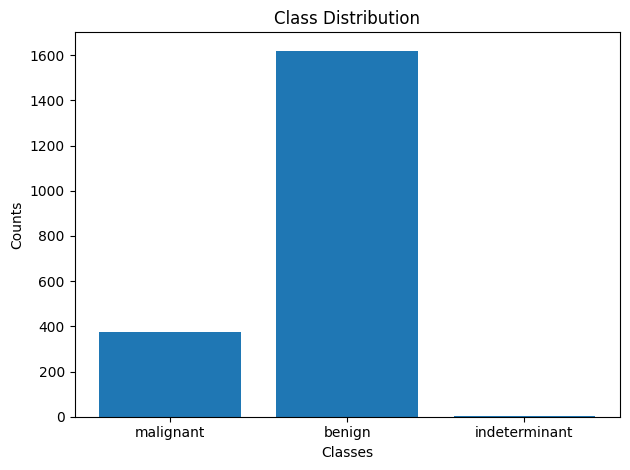

In [5]:
def count_images(path):
    count=0
    for i in os.listdir(path):
        count+=1
    return count

n_benign = count_images(image_path+'/benign')
n_malignant = count_images(image_path+'/malignant')
n_indeterminant = count_images('/kaggle/working/indeterminant')
print(f"There are {n_benign} benign images.")
print(f"There are {n_malignant} malignant images.")
print(f"There are {n_indeterminant} indeterminant images.")
classes_ds = classes + ['indeterminant'] 

plt.bar(classes_ds, [n_malignant, n_benign, n_indeterminant])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

/kaggle/working/dataset/malignant
/kaggle/working/dataset/benign
malignant, r, 24576000
malignant, g, 24576000
malignant, b, 24576000
benign, r, 24576000
benign, g, 24576000
benign, b, 24576000


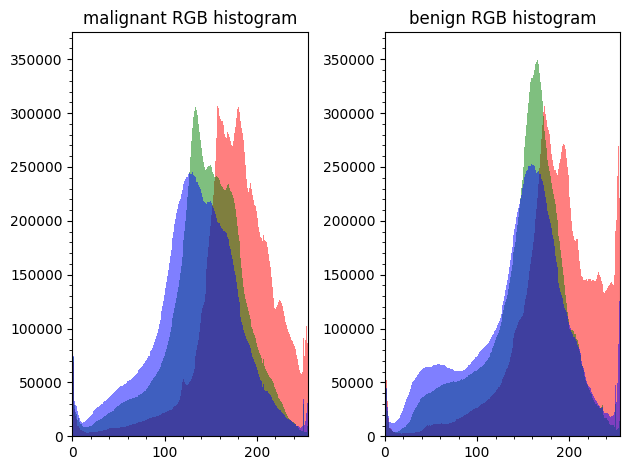

In [6]:
hist = {'malignant': {'r':[], 'g':[], 'b':[],},
        'benign': {'r':[], 'g':[], 'b':[]}}

for cls in classes:
    class_path = os.path.join(dataset, cls)
    print(class_path)
    image_files = sorted(os.listdir(class_path))[:n_malignant]

    for img in image_files:
        img_path = os.path.join(class_path, img)
        img = Image.open(img_path)
        img = img.resize((img_size[0], img_size[1]))

        img_array = np.array(img)

        hist[cls]['r'].append(img_array[:,:,0])
        hist[cls]['g'].append(img_array[:,:,1])
        hist[cls]['b'].append(img_array[:,:,2])

fig, axs = plt.subplots(1,2)
for i, cls in enumerate(classes):
    axs[i].set_title(f"{cls} RGB histogram")

    R = np.concatenate(hist[cls]['r'], axis=None)
    print(f"{cls}, r, {len(R)}")
    G = np.concatenate(hist[cls]['g'], axis=None)
    print(f"{cls}, g, {len(G)}")
    B = np.concatenate(hist[cls]['b'], axis=None)
    print(f"{cls}, b, {len(B)}")

    axs[i].hist(R, bins=256, color='r', alpha=0.5)
    axs[i].hist(G, bins=256, color='g', alpha=0.5)
    axs[i].hist(B, bins=256, color='b', alpha=0.5)
    axs[i].set_ylim([0, 3.75e5])
    axs[i].set_xlim([0,255])
    axs[i].minorticks_on()

plt.tight_layout()
plt.show()

# CNN

In [7]:
model2 = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3), 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')  
])

optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 639ms/step - accuracy: 0.7109 - loss: 9.8876 - val_accuracy: 0.1554 - val_loss: 11.3073
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 478ms/step - accuracy: 0.7935 - loss: 8.0705 - val_accuracy: 0.1554 - val_loss: 11.2756
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 451ms/step - accuracy: 0.7939 - loss: 7.5424 - val_accuracy: 0.1554 - val_loss: 10.6511
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 489ms/step - accuracy: 0.8461 - loss: 7.0466 - val_accuracy: 0.1554 - val_loss: 8.5284
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.8669 - loss: 6.6007 - val_accuracy: 0.1554 - val_loss: 10.3350
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - accuracy: 0.8750 - loss: 6.2311 - val_accuracy: 0.8446 - val_loss: 6.2235
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 442ms/step - accuracy: 0.9004 - loss: 5.8973 - val_accuracy: 0.8020 - val_loss: 5.9343
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 476ms/step - accuracy: 0.9101 - loss: 5.5539 - val_

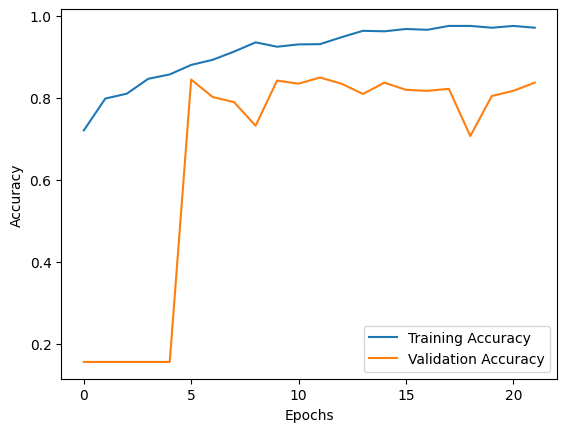

In [8]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=10,
                                         restore_best_weights=True)
history2 = model2.fit(ds_train, validation_data=ds_val, epochs=25, callbacks=[callback])

plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
def predict_image(img_path, model, classes):
    img = image.load_img(img_path, target_size=(img_size[0], img_size[1]))
    img_array = image.img_to_array(img)
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    img_tensor = normalization(img_tensor)

    prediction = model.predict(img_tensor)
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction)
    return img, predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


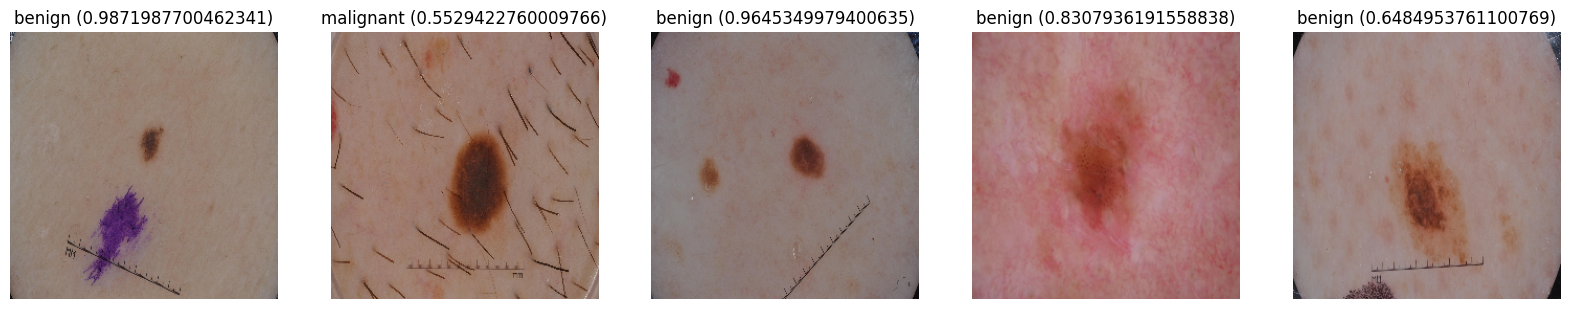

In [10]:
image_ind = [os.path.join('/kaggle/working/indeterminant', i) for i in os.listdir(indeterminant)]
n = len(image_ind)
fig, axes = plt.subplots(1,n, figsize=(20,n))
for i, img_path in enumerate(image_ind[:n]):
    img, predicted_class, confidence = predict_image(img_path, model2, classes)

    axes[i].imshow(img)
    axes[i].set_title(f"{predicted_class} ({confidence})")
    axes[i].axis("off")
plt.show()

In [11]:
def generator():
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(3, (3, 3), padding='same', activation='relu')(x) 
    return keras.Model(inputs, x)

def discriminator():
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    return keras.Model(inputs, x)

# Step 3: Define loss function
loss_object = keras.losses.MeanSquaredError()

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss)

def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

# Step 4: Create optimizer
generator_optimizer = keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=2e-4)

generator_photo_to_monet = generator()
discriminator_monet = discriminator()

def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generator_photo_to_monet(real_photo, training=True)
        cycled_photo = generator_photo_to_monet(fake_monet, training=True)
        same_monet = generator_photo_to_monet(real_monet, training=True)
        
        fake_monet_output = discriminator_monet(fake_monet, training=True)
        real_monet_output = discriminator_monet(real_monet, training=True)

        gen_loss = generator_loss(fake_monet_output)
        disc_loss = discriminator_loss(real_monet_output, fake_monet_output)
        cycle_consistency_loss = cycle_loss(real_photo, cycled_photo)
        identity_mapping_loss = identity_loss(real_monet, same_monet)

        total_gen_loss = gen_loss + cycle_consistency_loss + identity_mapping_loss
        total_disc_loss = disc_loss

    gradients_gen = tape.gradient(total_gen_loss, generator_photo_to_monet.trainable_variables)
    gradients_disc = tape.gradient(total_disc_loss, discriminator_monet.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator_photo_to_monet.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator_monet.trainable_variables))

    return total_gen_loss, total_disc_loss

In [12]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = (image * 2) - 1  # Normalize to [-1,1]
    return image

# use batches to load dataset as its resource friendlier
def load_dataset(folder):
    image_paths = glob.glob(os.path.join(folder, '*.jpg'))
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

In [13]:
dataset_malignant = load_dataset('/kaggle/working/dataset/malignant')
dataset_benign = load_dataset('/kaggle/working/dataset/benign')

EPOCHS = 100
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for real_malignant, real_benign in zip(dataset_malignant, dataset_benign):
        gen_loss, disc_loss = train_step(real_malignant, real_benign)
    print(f"Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")

Epoch 1/100
Generator Loss: 0.5330, Discriminator Loss: 0.2803
Epoch 2/100
Generator Loss: 0.4865, Discriminator Loss: 0.3235
Epoch 3/100
Generator Loss: 0.5243, Discriminator Loss: 0.3748
Epoch 4/100
Generator Loss: 0.5751, Discriminator Loss: 0.3580
Epoch 5/100
Generator Loss: 0.5453, Discriminator Loss: 0.3185
Epoch 6/100
Generator Loss: 0.5103, Discriminator Loss: 0.3152
Epoch 7/100
Generator Loss: 0.5279, Discriminator Loss: 0.2999
Epoch 8/100
Generator Loss: 0.5453, Discriminator Loss: 0.3161
Epoch 9/100
Generator Loss: 0.5359, Discriminator Loss: 0.3664
Epoch 10/100
Generator Loss: 0.5159, Discriminator Loss: 0.3358
Epoch 11/100
Generator Loss: 0.5143, Discriminator Loss: 0.3290
Epoch 12/100
Generator Loss: 0.5717, Discriminator Loss: 0.3908
Epoch 13/100
Generator Loss: 0.5757, Discriminator Loss: 0.4258
Epoch 14/100
Generator Loss: 0.5671, Discriminator Loss: 0.4212
Epoch 15/100
Generator Loss: 0.5466, Discriminator Loss: 0.3624
Epoch 16/100
Generator Loss: 0.5052, Discriminato

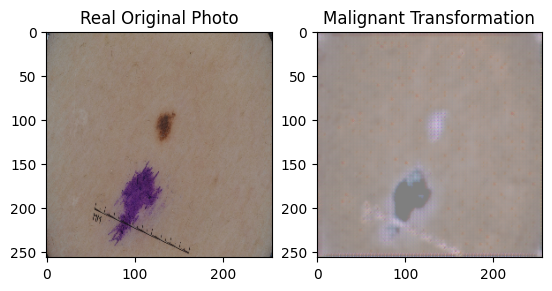

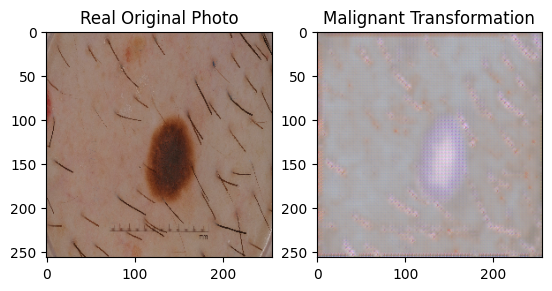

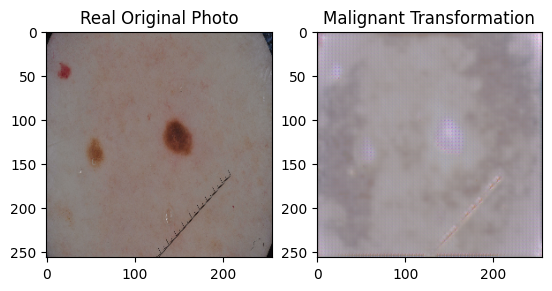

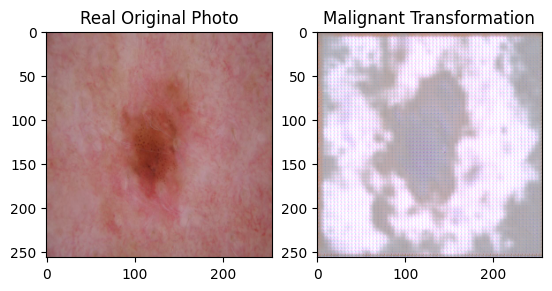

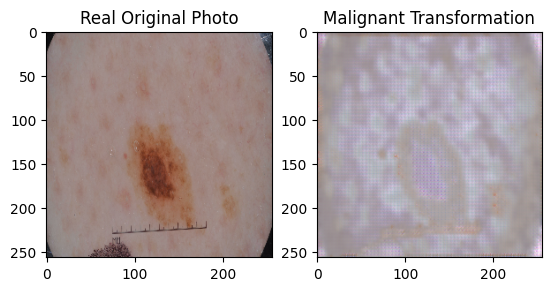

In [14]:
def generate_malignant_image(photo):
    generated_image = generator_photo_to_monet(tf.expand_dims(photo, axis=0))[0]
    return (generated_image.numpy()+1)/2  # Convert from [-1,1] to [0,1] for visualization

dataset_photo = load_dataset('/kaggle/working/indeterminant')
for photo in dataset_photo.take(5):
    malignant_image = generate_malignant_image(photo[0])

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow((photo[0]+1)/2)
    ax2.imshow(malignant_image)
    ax1.set_title('Real Original Photo')
    ax2.set_title('Malignant Transformation')
    plt.show()